In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1" # export OMP_NUM_THREADS=1
os.environ["OPENBLAS_NUM_THREADS"] = "1" # export OPENBLAS_NUM_THREADS=1
os.environ["MKL_NUM_THREADS"] = "1" # export MKL_NUM_THREADS=1
os.environ["VECLIB_MAXIMUM_THREADS"] = "1" # export VECLIB_MAXIMUM_THREADS=1
os.environ["NUMEXPR_NUM_THREADS"] = "1" # export NUMEXPR_NUM_THREADS=1

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import src.fitting as fitting
import src.multielec_utils as mutils
import statsmodels.api as sm
from scipy.spatial.distance import cdist
import time

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Path definitions
ANALYSIS_BASE = "/Volumes/Analysis"
MATFILE_BASE = "/Volumes/Scratch/Users/praful/triplet_gsort_matfiles_20220420"
gsort_path = None

dataset = "2020-10-06-7"
estim = "data003/data003-all"
wnoise = "kilosort_data000/data000"
electrical_path = os.path.join(ANALYSIS_BASE, dataset, estim)
vis_datapath = os.path.join(ANALYSIS_BASE, dataset, wnoise)

p = 3
cell = 296

### DATA CLEANING ###

X_expt_orig, probs_orig, T_orig = mutils.loadNewLVData(electrical_path, gsort_path, dataset, estim, wnoise, p, cell,
                                           load_from_mat=True, 
                                           MATFILE_BASE=MATFILE_BASE)
X_expt, probs, T = mutils.triplet_cleaning(X_expt_orig, probs_orig, T_orig, electrical_path, p)
X_all = mutils.get_stim_amps_newlv(electrical_path, p)

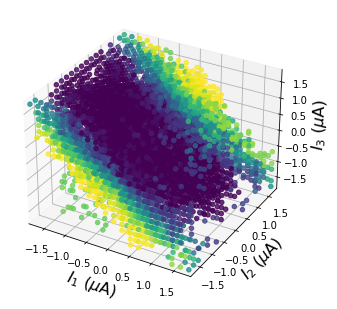

In [3]:
fig = plt.figure()
fig.clear()
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
plt.xlim(-1.8, 1.8)
plt.ylim(-1.8, 1.8)
ax.set_zlim(-1.8, 1.8)
ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

scat = ax.scatter(X_expt[:, 0], 
            X_expt[:, 1],
            X_expt[:, 2], marker='o', c=probs, s=20, alpha=0.8, vmin=0, vmax=1)

In [4]:
def get_performance_AL(X, probs_expt, params):
    probs_pred = fitting.sigmoidND_nonlinear(sm.add_constant(X, has_constant='add'),
                                             params)

    RMSE = np.sqrt(np.sum((probs_pred - probs_expt)**2) / len(X))

    return RMSE

In [5]:
method = 'L-BFGS-B'
jac = fitting.negLL_hotspot_jac
params_full = fitting.fit_triplet_surface(X_expt, probs, T, method=method, jac=jac)
performance_full = get_performance_AL(X_expt, probs, params_full)

In [6]:
performance_full

0.07469906170219896

In [7]:
params_full

array([[-6.17414121, -2.72289866, -3.67516165, -2.97281939],
       [-6.75086621,  2.87590446,  3.72676031,  3.19027118]])

In [8]:
init_samples = 50
max_samples = 150
batch_size = 10
exploit = 0.5
exploit_batch = int(exploit * batch_size)
explore_batch = batch_size - exploit_batch
proximity_thr = 0.2

repeats = 100
repeat_performance = []
repeat_performance_random = []
for m in range(repeats):
    print(m)
    
    init_inds = np.random.choice(len(X_expt), size=init_samples, replace=False)
    curr_inds = init_inds
    curr_inds_random = init_inds
    remaining_inds = np.setdiff1d(np.arange(len(X_expt), dtype=int), init_inds)
    remaining_inds_random = remaining_inds

    errors_active = []
    errors_random = []
    num_points = []

    while True:
        X_sub, probs_sub, T_sub = X_expt[curr_inds], probs[curr_inds], T[curr_inds]
        X_sub_random, probs_sub_random, T_sub_random = X_expt[curr_inds_random], probs[curr_inds_random], T[curr_inds_random]

        # start = time.time()
        curr_params = fitting.fit_triplet_surface(X_sub, probs_sub, T_sub, method=method, jac=jac)
        # print(time.time() - start)
        curr_pred = fitting.sigmoidND_nonlinear(sm.add_constant(X_all, has_constant='add'),
                                                curr_params)
        remaining_pred = fitting.sigmoidND_nonlinear(sm.add_constant(X_expt[remaining_inds], has_constant='add'),
                                                    curr_params)

        curr_params_random = fitting.fit_triplet_surface(X_sub_random, probs_sub_random, T_sub_random, method=method, jac=jac)

        curr_performance = get_performance_AL(X_expt, probs, curr_params)
        curr_performance_random = get_performance_AL(X_expt, probs, curr_params_random)

        errors_active.append(curr_performance)
        errors_random.append(curr_performance_random)
        num_points.append(len(curr_inds))
        # print(curr_performance, curr_performance_random)
        # print(len(curr_inds))

        if len(curr_inds) >= max_samples:
            break

        possible_inds = remaining_inds[np.where(np.absolute(remaining_pred - 0.5) <= proximity_thr)[0]]
        d_nmx = cdist(X_expt[possible_inds], X_sub)
        d_nx = np.amin(d_nmx, axis=1)

        exploit_inds = possible_inds[np.argsort(d_nx)[-exploit_batch:]]

        p_explore = np.amin(cdist(X_expt[np.setdiff1d(remaining_inds, exploit_inds)], X_sub), axis=1)**2
        p_explore = p_explore / np.sum(p_explore)
        explore_inds = np.random.choice(np.setdiff1d(remaining_inds, exploit_inds),
                                        p=p_explore,
                                        replace=False,
                                        size=explore_batch)
        next_inds = np.concatenate((exploit_inds, explore_inds))
        curr_inds = np.concatenate((curr_inds, next_inds))
        remaining_inds = np.setdiff1d(remaining_inds, curr_inds)

        next_inds_random = np.random.choice(remaining_inds_random, size=batch_size, replace=False)
        curr_inds_random = np.concatenate((curr_inds_random, next_inds_random))
        remaining_inds_random = np.setdiff1d(remaining_inds_random, curr_inds_random)
    
    repeat_performance.append(np.array(errors_active))
    repeat_performance_random.append(np.array(errors_random)) 

0


/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))


1
2
3


/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))


4


/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:75: RuntimeWarning: divide by zero encountered in log
  yPred2 = 1 / (1 + np.exp(-np.log(prod)))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:86: RuntimeWarning: divide by zero encountered in log
  NLL2 = np.sum(np.log(1 + prod) - y * np.log(prod))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:86: RuntimeWarning: invalid value encountered in multiply
  NLL2 = np.sum(np.log(1 + prod) - y * np.log(prod))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:130: RuntimeWarning: invalid value encountered in true_divide
  term2 = -X.T @ (y * np.exp(X @ w[i].T) * factors[i] / prod)
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:130: RuntimeWarning: divide by zero encountered in true_divide
  term2 = -X.T @ (y * np.exp(X @ w[i].T) * factors[i] / prod)
/Vo

5


/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))


6
7
8
9
10


/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:72: RuntimeWarning: overflow encountered in exp
  prod *= (1 + np.exp(X @ w[i].T))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:75: RuntimeWarning: divide by zero encountered in log
  yPred2 = 1 / (1 + np.exp(-np.log(prod)))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:86: RuntimeWarning: divide by zero encountered in log
  NLL2 = np.sum(np.log(1 + prod) - y * np.log(prod))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:86: RuntimeWarning: invalid value encountered in multiply
  NLL2 = np.sum(np.log(1 + prod) - y * np.log(prod))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:86: RuntimeWarning: invalid value encountered in subtract
  NLL2 = np.sum(np.log(1 + prod) - y * np.log(prod))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:113: RuntimeWarning: overflow encountered in exp
  prod = prod * (1 + np.exp(X @ w[i].T))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:123: Runt

11


/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))


12


/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))


13
14
15
16
17


/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))


18
19


/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:72: RuntimeWarning: overflow encountered in exp
  prod *= (1 + np.exp(X @ w[i].T))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:75: RuntimeWarning: divide by zero encountered in log
  yPred2 = 1 / (1 + np.exp(-np.log(prod)))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:86: RuntimeWarning: divide by zero encountered in log
  NLL2 = np.sum(np.log(1 + prod) - y * np.log(prod))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:86: RuntimeWarning: invalid value encountered in multiply
  NLL2 = np.sum(np.log(1 + prod) - y * np.log(prod))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:86: RuntimeWarning: invalid value encountered in subtract
  NLL2 = np.sum(np.log(1 + prod) - y * np.log(prod))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:11

20


/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))


21
22


/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:72: RuntimeWarning: overflow encountered in exp
  prod *= (1 + np.exp(X @ w[i].T))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:72: RuntimeWarning: overflow encountered in multiply
  prod *= (1 + np.exp(X @ w[i].T))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:86: RuntimeWarning: invalid value encountered in multiply
  NLL2 = np.sum(np.log(1 + prod) - y * np.log(prod))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:86: RuntimeWarning: invalid value encountered in subtract
  NLL2 = np.sum(np.log(1 + prod) - y * np.log(prod))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:113: RuntimeWarning: overflow encountered in exp
  prod = prod * (1 + np.exp(X @ w[i].T))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:113: RuntimeWarning: overflo

23


/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:72: RuntimeWarning: overflow encountered in exp
  prod *= (1 + np.exp(X @ w[i].T))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:72: RuntimeWarning: overflow encountered in multiply
  prod *= (1 + np.exp(X @ w[i].T))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:86: RuntimeWarning: invalid value encountered in multiply
  NLL2 = np.sum(np.log(1 + prod) - y * np.log(prod))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:86: RuntimeWarning: invalid value encountered in subtract
  NLL2 = np.sum(np.log(1 + prod) - y * np.log(prod))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:113: RuntimeWarning: 

24
25


/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))


26
27


/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:72: RuntimeWarning: overflow encountered in exp
  prod *= (1 + np.exp(X @ w[i].T))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:86: RuntimeWarning: invalid value encountered in multiply
  NLL2 = np.sum(np.log(1 + prod) - y * np.log(prod))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:86: RuntimeWarning: invalid value encountered in subtract
  NLL2 = np.sum(np.log(1 + prod) - y * np.log(prod))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:113: RuntimeWarning: overflow encountered in exp
  prod = prod * (1 + np.exp(X @ w[i].T))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:123: RuntimeWarning: overflow encountered in exp
  factors[i] = factors[i] + np.exp(X @ np.sum(w[other_combo], axis=0).T)
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:130: RuntimeWarning: invalid value encountered in multiply
  term2 = -X.T @ (y * np.exp(X @ w[i].T) * factors[i] / prod)
/Volumes/Lab/Users/praful/

28


/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))


29


/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:75: RuntimeWarning: divide by zero encountered in log
  yPred2 = 1 / (1 + np.exp(-np.log(prod)))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:86: RuntimeWarning: divide by zero encountered in log
  NLL2 = np.sum(np.log(1 + prod) - y * np.log(prod))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:86: RuntimeWarning: invalid value encountered in multiply
  NLL2 = np.sum(np.log(1 + prod) - y * np.log(prod))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:130: RuntimeWarning: divide by zero encountered in true_divide
  term2 = -X.T @ (y * np.exp(X @ w[i].T) * factors[i] / prod)
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:130: RuntimeWarning: invalid value encountered in true_divide
  term2 = -X.T @ (y * np.exp(X @ w[i].T) * factors[i] / prod)
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:72: RuntimeWarning: overflow encountered in exp
  prod *= (1 + np.exp(X @ w[i].T))
/Volumes/Lab/User

30


/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))


31


/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))


32
33
34
35


/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))


36
37
38


/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))


39
40


/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))


41
42


/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))


43
44
45
46


/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:75: RuntimeWarning: divide by zero encountered in log
  yPred2 = 1 / (1 + np.exp(-np.log(prod)))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:86: RuntimeWarning: divide by zero encountered in log
  NLL2 = np.sum(np.log(1 + prod) - y * np.log(prod))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:86: RuntimeWarning: invalid value encountered in multiply
  NLL2 = np.sum(np.log(1 + prod) - y * np.log(prod))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:130: RuntimeWarning: divide by zero encountered in true_divide
  term2 = -X.T @ (y * np.exp(X @ w[i].T) * factors[i] / prod)
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:130: RuntimeWarning: invalid value encountered in true_divide
  term2 = -X.T @ (y * np.exp(X @ w[i].T) * factors[i] / prod)
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:72: RuntimeWarning: overflow encountered in exp
  prod *= (1 + np.exp(X @ w[i].T))
/Volumes/Lab/User

47
48
49
50


/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))


51


/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:75: RuntimeWarning: divide by zero encountered in log
  yPred2 = 1 / (1 + np.exp(-np.log(prod)))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:86: RuntimeWarning: divide by zero encountered in log
  NLL2 = np.sum(np.log(1 + prod) - y * np.log(prod))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:86: RuntimeWarning: invalid value encountered in multiply
  NLL2 = np.sum(np.log(1 + prod) - y * np.log(prod))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:130: RuntimeWarning: invalid value encountered in true_divide
  term2 = -X.T @ (y * np.exp(X @ w[i].T) * factors[i] / prod)
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:72: RuntimeWarning: overflow encountered in exp
  prod *= (1 + np.exp(X @ w[i].T))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:86: RuntimeWarning: invalid value encountered in subtract
  NLL2 = np.sum(np.log(1 + prod) - y * np.log(prod))
/Volumes/Lab/Users/praful/multi

52
53


/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))


54
55
56
57
58


/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))


59


/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))


60
61


/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:72: RuntimeWarning: overflow encountered in exp
  prod *= (1 + np.exp(X @ w[i].T))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:75: RuntimeWarning: divide by zero encountered in log
  yPred2 = 1 / (1 + np.exp(-np.log(prod)))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:86: RuntimeWarning: divide by zero encountered in log
  NLL2 = np.sum(np.log(1 + prod) - y * np.log(prod))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:86: RuntimeWarning: invalid value encountered in multiply
  NLL2 = np.sum(np.log(1 + prod) - y * np.log(prod))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:86: RuntimeWarning: invalid value encountered in subtract
  NLL2 = np.sum(np.log(1 + prod) - y * np.log(prod))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:11

62
63


/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:75: RuntimeWarning: divide by zero encountered in log
  yPred2 = 1 / (1 + np.exp(-np.log(prod)))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:86: RuntimeWarning: divide by zero encountered in log
  NLL2 = np.sum(np.log(1 + prod) - y * np.log(prod))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:86: RuntimeWarning: invalid value encountered in multiply
  NLL2 = np.sum(np.log(1 + prod) - y * np.log(prod))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:130: RuntimeWarning: divide by zero encountered in true_divide
  term2 = -X.T @ (y * np.exp(X @ w[i].T) * factors[i] / prod)
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:130: RuntimeWarning: invalid value encountered in true_divide
  term2 = -X.T @ (y * np.exp(X @ w[i].T) * factors[i] / prod)
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:72: RuntimeWarning: overflow encountered in exp
  prod *= (1 + np.exp(X @ w[i].T))
/Volumes/Lab/User

64


/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))


65
66
67
68


/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:75: RuntimeWarning: divide by zero encountered in log
  yPred2 = 1 / (1 + np.exp(-np.log(prod)))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:86: RuntimeWarning: divide by zero encountered in log
  NLL2 = np.sum(np.log(1 + prod) - y * np.log(prod))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:86: RuntimeWarning: invalid value encountered in multiply
  NLL2 = np.sum(np.log(1 + prod) - y * np.log(prod))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:130: RuntimeWarning: divide by zero encountered in true_divide
  term2 = -X.T @ (y * np.exp(X @ w[i].T) * factors[i] / prod)
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:130: RuntimeWarning: invalid value encountered in true_divide
  term2 = -X.T @ (y * np.exp(X @ w[i].T) * factors[i] / prod)
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:72: RuntimeWarning: overflow encountered in exp
  prod *= (1 + np.exp(X @ w[i].T))
/Volumes/Lab/User

69


/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))


70


/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))


71
72
73
74


/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))


75


/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))


76


/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))


77


/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))


78
79
80


/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:72: RuntimeWarning: overflow encountered in exp
  prod *= (1 + np.exp(X @ w[i].T))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:72: RuntimeWarning: overflow encountered in multiply
  prod *= (1 + np.exp(X @ w[i].T))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:86: RuntimeWarning: invalid value encountered in multiply
  NLL2 = np.sum(np.log(1 + prod) - y * np.log(prod))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:86: RuntimeWarning: invalid value encountered in subtract
  NLL2 = np.sum(np.log(1 + prod) - y * np.log(prod))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:113: RuntimeWarning: overflow encountered in exp
  prod = prod * (1 + np.exp(X @ w[i].T))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:113: RuntimeWarning: overflow encountered in multiply
  prod = prod * (1 + np.exp(X @ w[i].T))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:123: RuntimeWarning: overflow 

81


/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:72: RuntimeWarning: overflow encountered in exp
  prod *= (1 + np.exp(X @ w[i].T))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:72: RuntimeWarning: overflow encountered in multiply
  prod *= (1 + np.exp(X @ w[i].T))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:75: RuntimeWarning: divide by zero encountered in log
  yPred2 = 1 / (1 + np.exp(-np.log(prod)))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:86: RuntimeWarning: divide by zero encountered in log
  NLL2 = np.sum(np.log(1 + prod) - y * np.log(prod))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:86: RuntimeWarning: invalid value encountered in multiply
  NLL2 = np.sum(np.log(1 + prod) - y * np.log(prod))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:86: RuntimeWarning: invalid value encountered in subtract
  NLL2 = np.sum(np.log(1 + prod) - y * np.log(prod))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:113: Runtim

82
83


/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))


84


/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))


85


/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))


86


/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:72: RuntimeWarning: overflow encountered in exp
  prod *= (1 + np.exp(X @ w[i].T))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:86: RuntimeWarning: invalid value encountered in multiply
  NLL2 = np.sum(np.log(1 + prod) - y * np.log(prod))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:86: RuntimeWarning: invalid value encountered in subtract
  NLL2 = np.sum(np.log(1 + prod) - y * np.log(prod))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:113: RuntimeWarning: overflow encountered in exp
  prod = prod * (1 + np.exp(X @ w[i].T))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:123: RuntimeWarning: overflow encountered in exp
  factors[i] = factors[i] + np.exp(X @ np.sum(w[other_combo], axis=0).T)
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:130: RuntimeWarning: invalid value encountered in multiply
  term2 = -X.T @ (y * np.exp(X @ w[i].T) * factors[i] / prod)
/Volumes/Lab/Users/praful/

87


/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))


88
89
90


/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overf

91


/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))


92


/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:129: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))


93
94
95
96
97
98
99


/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:75: RuntimeWarning: divide by zero encountered in log
  yPred2 = 1 / (1 + np.exp(-np.log(prod)))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:86: RuntimeWarning: divide by zero encountered in log
  NLL2 = np.sum(np.log(1 + prod) - y * np.log(prod))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:86: RuntimeWarning: invalid value encountered in multiply
  NLL2 = np.sum(np.log(1 + prod) - y * np.log(prod))
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:130: RuntimeWarning: divide by zero encountered in true_divide
  term2 = -X.T @ (y * np.exp(X @ w[i].T) * factors[i] / prod)
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:130: RuntimeWarning: invalid value encountered in true_divide
  term2 = -X.T @ (y * np.exp(X @ w[i].T) * factors[i] / prod)
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:72: RuntimeWarning: overflow encountered in exp
  prod *= (1 + np.exp(X @ w[i].T))
/Volumes/Lab/User

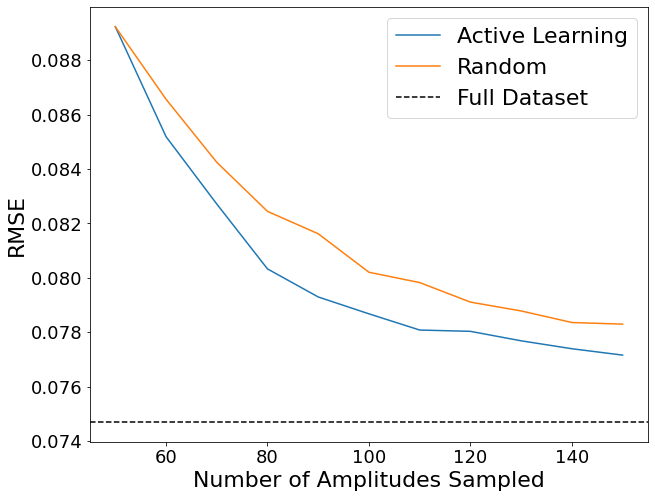

In [9]:
plt.figure(10, figsize=(10, 8))
plt.plot(np.array(num_points),
         np.mean(np.array(repeat_performance), axis=0), label='Active Learning')
plt.plot(np.array(num_points),
         np.mean(np.array(repeat_performance_random), axis=0), label='Random')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('RMSE', fontsize=22)
plt.xlabel('Number of Amplitudes Sampled', fontsize=22)
plt.axhline(performance_full, linestyle='--', c='k', label='Full Dataset')
plt.legend(fontsize=22)

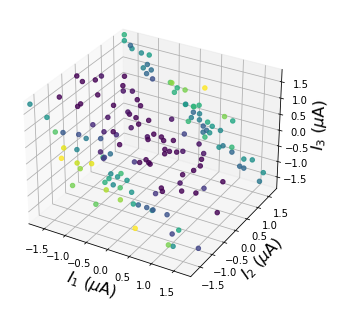

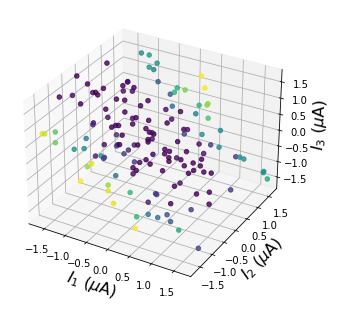

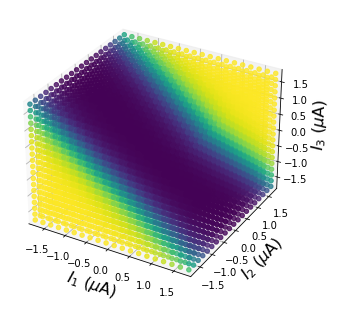

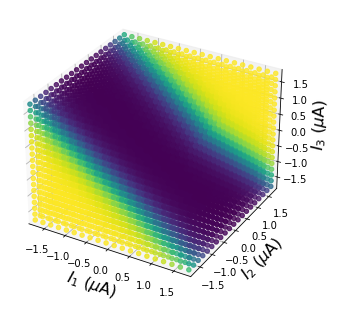

In [10]:
fig = plt.figure(0)
fig.clear()
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
plt.xlim(-1.8, 1.8)
plt.ylim(-1.8, 1.8)
ax.set_zlim(-1.8, 1.8)
ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

scat = ax.scatter(X_sub[:, 0], 
            X_sub[:, 1],
            X_sub[:, 2], marker='o', c=probs_sub, s=20, alpha=0.8, vmin=0, vmax=1)

fig = plt.figure(3)
fig.clear()
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
plt.xlim(-1.8, 1.8)
plt.ylim(-1.8, 1.8)
ax.set_zlim(-1.8, 1.8)
ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

scat = ax.scatter(X_sub_random[:, 0], 
            X_sub_random[:, 1],
            X_sub_random[:, 2], marker='o', c=probs_sub_random, s=20, alpha=0.8, vmin=0, vmax=1)

fig = plt.figure(1)
fig.clear()
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
plt.xlim(-1.8, 1.8)
plt.ylim(-1.8, 1.8)
ax.set_zlim(-1.8, 1.8)
ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

scat = ax.scatter(X_all[:, 0], 
            X_all[:, 1],
            X_all[:, 2], marker='o', c=curr_pred, s=20, alpha=0.8, vmin=0, vmax=1)

full_pred = fitting.sigmoidND_nonlinear(sm.add_constant(X_all, has_constant='add'),
                                            params_full)

fig = plt.figure(2)
fig.clear()
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
plt.xlim(-1.8, 1.8)
plt.ylim(-1.8, 1.8)
ax.set_zlim(-1.8, 1.8)
ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

scat = ax.scatter(X_all[:, 0], 
            X_all[:, 1],
            X_all[:, 2], marker='o', c=full_pred, s=20, alpha=0.8, vmin=0, vmax=1)

In [11]:
curr_params, params_full

(array([[-6.0825364 ,  2.64322164,  3.41212427,  2.84256687],
        [-5.63420639, -2.53364531, -3.36633313, -2.83247539]]),
 array([[-6.17414121, -2.72289866, -3.67516165, -2.97281939],
        [-6.75086621,  2.87590446,  3.72676031,  3.19027118]]))